# Analytic solution to the neutron burst
This notebook utilizes the analytic solution to the linear acyclic reaction to study the neutron burst problem. This process allows for a deeper understanding of how the cross sections and neutron exposures impact the contribution of one species to another. We begin with preliminaries followed by the ...


## Preliminaries 
We begin by importing the necessary libraries:

In [1]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy', 'wnutils', 'wnnet', 'matplotlib', 'ipywidgets', 'wnpoly'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
from scipy.integrate import solve_ivp
import wnutils.xml as wx
import wnpoly as wp
import matplotlib.pyplot as plt
from statistics import geometric_mean
import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
import math

Next, we import the solar xml file for initial compositions and a network file for computing reaction cross sections:

In [2]:
solar_xml = wx.Xml(
        io.BytesIO(requests.get("https://osf.io/w8ktc/download").content))
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

Now we define the isotopes that are included in the network. It is important that the isotopes defined are of the same species and increasing consecutive mass number (this is a condition for a neutron burst network):

In [3]:
species = ['ca40','ca41','ca42','ca43','ca44','ca45','ca46']
#species = ['zr90', 'zr91','zr92','zr93','zr94','zr95','zr96','zr97','zr98','zr99','zr100']

Next, to compute the neutron capture cross sections we use [wnnet](https://readthedocs.io/wnnet). To start we define a temperature. The temperature during the neutron burst will be roughly constant, so defining a single temperature is a good approximation: 

In [4]:
t9 = 0.7

induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
reacs = net.compute_rates(t9, reac_xpath = induced_reac_xpath)
rates = []
for key, values in list(reacs.items()):
    rates.append(values[0])
    
ordered_dict = {}

for sp in species:
    for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
        if sp in value.reactants:
            ordered_dict[sp] = reacs[key][0]
            
T = t9 * 10**9
k = wn.consts.GSL_CONST_CGS_BOLTZMANN
N_A = wn.consts.GSL_CONST_NUM_AVOGADRO
m_n = wn.consts.GSL_CONST_CGS_MASS_NEUTRON
v_T = np.sqrt((2*k*T)/m_n)
sigs_array = []
for key, value in ordered_dict.items():
    sigs_array.append(1000*value/(v_T*N_A*wn.consts.GSL_CONST_CGSM_BARN))

Now, we can print out the results:

In [5]:
from IPython.display import display, Math

for i in range(len(sigs_array)):
    latex_name = solar_xml.get_latex_names([species[i]])[species[i]]
    sig_value = sigs_array[i]

    latex_str = r"$\sigma_n$({}) : {} $\, \text{{mb}}^{{-1}}$".format(latex_name, sig_value)

    display(Math(latex_str))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

For the analytic solution to the linear acyclic reaction network we need the geometric mean for all paths and the coefficients of the bell polynomials corresponding to the cross sections in the path. Here we define a function to return these values:

In [6]:
def get_variables(sigs_array, j):
    s = wp.symm.Complete()
    h = s.compute_normalized(sigs_array, j) 
    b = wp.bell.Bell()
    x = b.invert(h)
    if len(sigs_array)>1:
        gmean = geometric_mean(sigs_array[0:len(sigs_array)-1])
    else:
        gmean = 1
    return [len(sigs_array), gmean, x]

Now, we can look at how the relative contribution of one species to another changes with increasing exposures. 

## The relative contribution - G
The G value arises from the solution to the linear acyclic reaction network. Here it will be represented as $G(Z,A,\tau;Z, A', 0)$, or simply the contribution from species (Z,A') to species (Z,A). Z is the proton number and A is the mass number (note that since the proton number is not changing in the neutron burst the function maps between species with different neutron numbers). From the solution to the linear acyclic network we get:

\begin{gather}
G(Z,A,\tau;Z, A', 0) = \frac{(\sigma \tau)^{N-1}}{(N-1)!}exp\Big({\sum_{j=0}^\infty x_j \frac{(-\tau)^j}{j!}}\Big)\notag
\end{gather}

The $\sigma$ is the geometric mean of the cross sections between (Z,A') and (Z,A), N is the number of species, $\tau$ is the exposure, and the $x_j$s are bell polynomial coefficients relating to the cross sections between (Z, A') and (Z,A). The bell polynomial coefficients are computed using the wnpoly python package and the previously defined "get_variables" function. Note also that the function is expressed as an infinite sum, but for the neutron burst only three terms is a realistic approximation. This is what we aim to showcase here. 

First we define a function to compute the numerical solution and the function to compute the $G(Z,A,\tau;Z,A',0)$:

In [7]:
def numerical(t, y, sigmas):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigmas[0]*y[0]
    for i in range(1, N):
        result[i] = sigmas[i-1]*y[i-1] - sigmas[i]*y[i]
    return result

def analytic(tau, tup):
    result = 0
    for n in range(len(tup[2])):
        result += tup[2][n] * np.power(-tau, n) / math.factorial(n)
    return np.power(tup[1] * tau, tup[0]-1) * np.exp(result) / math.factorial(tup[0]-1)

Now we can see how the G values compare to the numeric solution with only three terms (j=2) kept: 

In [8]:
def compare(sp1, sp2, j):
    N = len(species[species.index(sp1):species.index(sp2)+1])
    sigs = sigs_array[species.index(sp1): species.index(sp2)+1]
    tup = get_variables(sigs, j) 
    print('******************************************************************************************')
    print("The variables required to compute the relative contribution of " +
          "{} to {} are: N = {}, $\sigma$ = {}, and x = {}".format(sp1, sp2, tup[0], tup[1], tup[2]))
    print('******************************************************************************************')
    abunds = np.zeros(N)
    abunds[0] = 1
    tau = np.linspace(0, 0.2, 30) 
    sol = solve_ivp(numerical, [tau[0], tau[len(tau)-1]], abunds, args = (sigs,), max_step = 0.001)
    plt.plot(sol.t, sol.y[-1], label = 'numerical')
    plt.plot(tau, analytic(tau,tup), 'o', label = 'G')
    plt.xlabel(r'$\tau$')
    plt.legend()
    
interact(compare, 
        sp1 = widgets.Dropdown(options = species),
        sp2 = widgets.Dropdown(options = species), 
        j = widgets.BoundedIntText(value = 2, min = 2, max = 10))

interactive(children=(Dropdown(description='sp1', options=('ca40', 'ca41', 'ca42', 'ca43', 'ca44', 'ca45', 'ca…

<function __main__.compare(sp1, sp2, j)>

### Relative contributions of all species 
One can also see the contributions of all species to another. This involves computing one row of the so called G matrix (i.e. $G_{j1}$, $G_{j2}$, ... , $G_{jj}$). 

In [9]:
def contributions(sp, j):
    index = species.index(sp)
    tau = np.linspace(0, 0.2, 100)
    G = np.empty(index+1, dtype = 'object')
    for i in range(index+1):
        sigs = sigs_array[i:index+1]
        G[i] = analytic(tau, get_variables(sigs, j))
    for i in range(len(G)):
        plt.plot(tau, G[i], label = solar_xml.get_latex_names([species[i]])[species[i]])
    plt.legend()
    plt.ylabel('G')
    plt.xlabel(r'$\tau$')
    plt.show()

interact(contributions, 
        sp = widgets.Dropdown(options = species), 
        j = widgets.BoundedIntText(value = 2, min = 2, max = 10))

interactive(children=(Dropdown(description='sp', options=('ca40', 'ca41', 'ca42', 'ca43', 'ca44', 'ca45', 'ca4…

<function __main__.contributions(sp, j)>

Now that we see the analytic solution is reliable in the exposure range we are considering, we can look at the abundances of species in the analytic solution. 

## The abundances - Y
The abundance of species (Z,A): Y(Z,A,$\tau$) is given by the contribution of all species along the path multiplied by their relavent initial abundance Y(Z,A,0):
\begin{gather}
Y(Z,A,\tau) = \sum_{A'<=A} G(Z,A,\tau;Z,A',0)\,Y(Z,A',0)
\end{gather}


For this we need the initial abundances, taken in this notebook to be solar and retrieved from the solar xml file loaded in previously. First we get the abundances:

In [10]:
def get_abunds(solar_xml):
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    a = []
    d = {}

    for isotope in species:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        if s_tup in x_solar:
            a.append(s_tup[2])
            d[s_tup[0]] = x_solar[s_tup] / tup[1]
        else:
            a.append(s_tup[2])
            d[s_tup[0]] = 0
            
    return a, d

a, y0 = get_abunds(solar_xml)
y0_list = []
for sp in species:
    y0_list.append(y0[sp])
y0_array = np.array(y0_list)

Now to compute the abundances after some exposure $\tau$ we need to compute the entire matrix of relative contributions:

In [11]:
matrix = np.empty((len(species),len(species)), dtype = "object")
for i in range(len(species)):
    for j in range(len(species)):
        if j<=i: 
            sigmas = sigs_array[j:i+1]
            matrix[i,j] = get_variables(sigmas, 2)
        else:
            matrix[i,j] = 0

With this we can compute the G matrix which will have the relative contributions for every exposure in the defined tau:

In [12]:
tau = np.linspace(0, 0.2, 100)
Gs = np.empty((len(species),len(species)), dtype = "object")
for i in range(len(species)):
    for j in range(len(species)):
        if j<=i:
            Gs[i,j] = analytic(tau, matrix[i,j])
        else:
            Gs[i,j] = 0

Now, a dot product between the G matrix and initial abundance array yields the abundances as a function of tau:

In [13]:
abundances = np.dot(Gs,y0_array)

Now we can plot the abundances to see how they change vs tau:

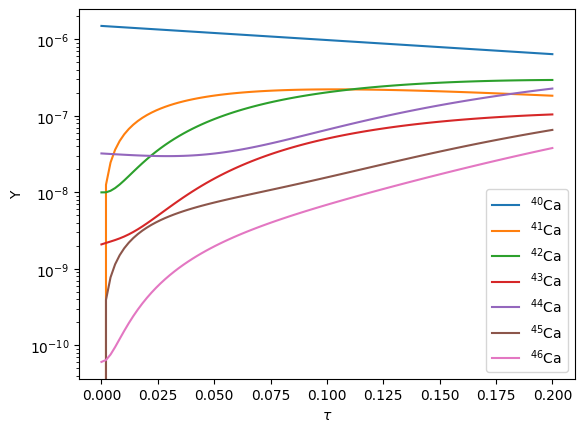

In [14]:
for i in range(len(species)):
    plt.plot(tau,abundances[i], label = solar_xml.get_latex_names([species[i]])[species[i]])
    
plt.legend()
plt.ylabel('Y')
plt.xlabel(r'$\tau$')
plt.yscale('log')
plt.show()

### Abundance contributions for each species 
Similar to before, we can look at the abundance contribution for all species by multiplying one row of the G matrix by the initial abundances:

In [15]:
def compare_abunds(sp):
    index = species.index(sp)
    G_row = Gs[index, :]
    for i in range(index+1):
        plt.plot(tau, G_row[i]*y0_array[i], label = solar_xml.get_latex_names([species[i]])[species[i]])
    plt.legend()

interact(compare_abunds, 
        sp = widgets.Dropdown(options = species), 
        j = widgets.BoundedIntText(value = 2, min = 2, max = 10))

interactive(children=(Dropdown(description='sp', options=('ca40', 'ca41', 'ca42', 'ca43', 'ca44', 'ca45', 'ca4…

<function __main__.compare_abunds(sp)>

# Distributions of Exposure
We consider the following:
\begin{gather}
\int_0^{\tau_{max}} \,d\tau\,\rho(\tau) = 1
\end{gather}
to define the value $\rho(\tau)$ as the probability distribution that a region will see a given exposure. The integral:
\begin{gather}
G[\rho] = \int_0^{\tau_{max}} d\tau \, G(Z,A',\tau ; Z,A,0)\, \rho(\tau)
\end{gather}
Defines the functional G[$\rho$] which when multiplied by the initial abundances gives the final abundance of a species in some region that experiences the distribution of exposures defined. First we define the distribution. One may use any distribution they are interested in by simply modifying the 'dist' function, but here we use a gaussian centered at $\tau =0.07$:

In [46]:
import scipy.integrate as integrate 

def dist(tau):
#    return np.exp(-(tau-0.07)**2)
    return np.exp(-(tau)**2)

def norm(tau, tau_max):
    integral, _ = integrate.quad(dist, 0, tau_max)
    a = 1/integral
    return a*dist(tau)

def Grho_integrand(tau, tup, tau_max):
    return analytic(tau, tup)*norm(tau, tau_max)

Now, we define $\tau_{max}$ and integrate numerically to get the $G[\rho]$ matrix elements. 

In [47]:
tau_max = 0.2
Grho = np.empty((len(species),len(species)))
for i in range(len(species)):
    for j in range(len(species)):
        if j<=i: 
            Grho[i,j], _ = integrate.quad(Grho_integrand, 0, tau_max, args = (matrix[i,j], tau_max))
        else:
            Grho[i,j] = 0

Finally we compute the abundances from this distribution of exposures 

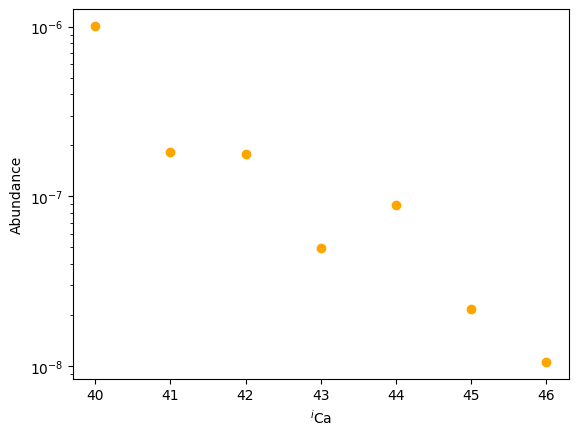

In [53]:
ys_dist = np.dot(Grho, y0_array)
for i in range(len(ys)):
    plt.plot(a[i], ys_dist[i], 'o', color='orange')
plt.yscale('log')
plt.ylabel('Abundance')
plt.xlabel(r'$^{i}$Ca')
plt.show()

One can consider the distribution of exposures calculation equivalent to mixing multiple layers of a star that experience different neutron exposures. For this reason it is reasonable to consider this mixture in the context of replicating the abundances in presolar grains. 

## Comparison to data
